# LAB 1

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from scipy.optimize import root as get_root
from sklearn.cluster import DBSCAN, KMeans
from numba import njit
from sympy import *

plt.rcParams["figure.figsize"] = [15, 7]

# Task 1

In [21]:
interval = (2.8, 4)  # start, end
accuracy = 0.0001
reps = 1000  # number of repetitions
a = 1e-2

R = np.arange(*interval, accuracy)
lims = []
lims2 = [] # initialize for the plot with perturbations

def perturbation(x):
    return a*x**4

for r in tqdm(R):
    temp_lims = []
    temp_lims2 = [] # initialize temp lists for storing data
    initial_val = np.random.rand()
    temp_lims.append(initial_val)
    temp_lims2.append(initial_val + perturbation(initial_val)) # creating the same initial condition as the perturbed version
    
    for i in range(reps-1):
        val = r*temp_lims[i]*(1-temp_lims[i])
        temp_lims.append(val)
        temp_lims2.append(val + perturbation(val)) # store values with perturbation
    
    lims.append(temp_lims)
    lims2.append(temp_lims2) # store temp lists in main lists
    
lims = np.array(lims)
lims2 = np.array(lims2)
lims.shape

100%|██████████| 12001/12001 [00:17<00:00, 699.18it/s]


(12001, 1000)

More optimized plotting

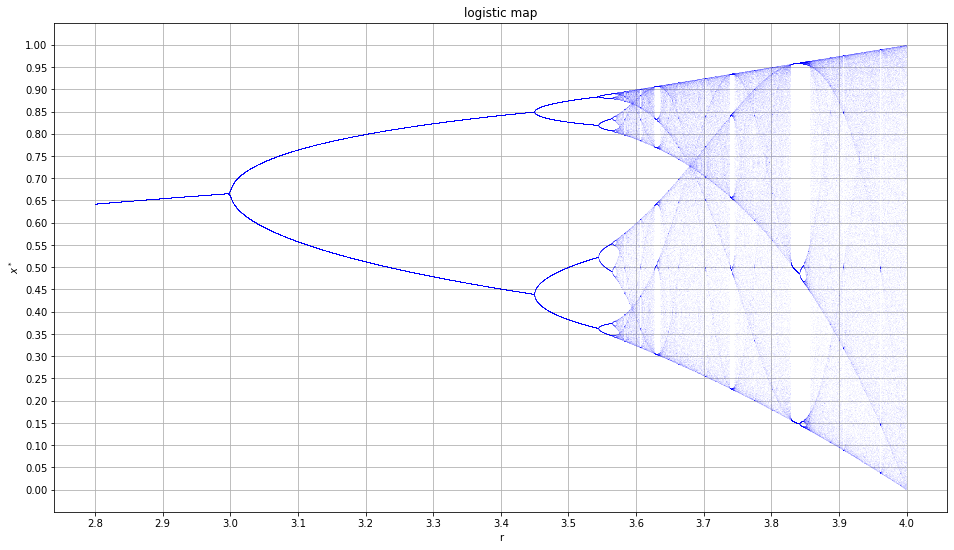

In [45]:
numtoplot = 50

fig, biax = plt.subplots(figsize=(16, 9))

# create arrays of x-coordinates and y-coordinates for unperturbed data
r_vals = np.arange(*interval, accuracy)
x_vals = lims[:, -numtoplot:]
r_broadcasted = np.broadcast_to(r_vals[:, None], (len(r_vals), numtoplot))
biax.plot(r_broadcasted.flatten(), x_vals.flatten(), 'b.', markersize=.02)

# create arrays of x-coordinates and y-coordinates for perturbed data
#x2_vals = lims2[:, -numtoplot:]
#biax.plot(r_broadcasted.flatten(), x2_vals.flatten(), 'r.', markersize=.02)

biax.set(xlabel='r', ylabel='$x^*$', title='logistic map')
plt.xticks(np.arange(*interval, 0.1))
plt.yticks(np.arange(0, 1+0.05, 0.05))
plt.grid()
#plt.legend()
#plt.show()
#plt.savefig("logistic map (blue) - perturbed map (red)", bbox_inches="tight")

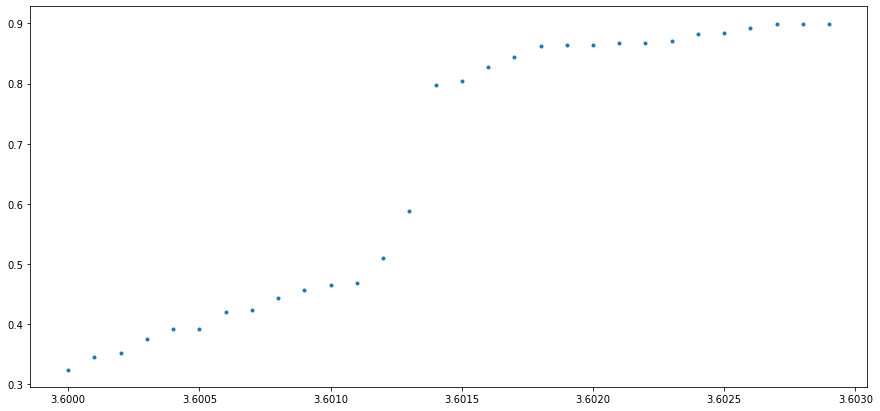

In [84]:
def count_points_in_interval(X, r_min, r_max):
    filtered_points = X[:, (X[0] >= r_min) & (X[0] <= r_max)]
    return filtered_points

R = np.arange(*interval, accuracy)
X = np.c_[R, lims[:, -1]].T

r_min = 3.6
r_max = 3.603

points = count_points_in_interval(X, r_min, r_max)


plt.plot(*np.sort(points, axis=-1), ".")
#np.diff(np.sort(points, axis=-1)[0])
#plt.xticks(np.arange(0,0.0010,0.0001));

# Task 2
Compute the Feigenbaum constants $\alpha\approx 2.5029$ and $\beta\approx4.6692$
for both maps.

## Finding the Lyapunov exponent

In [85]:
def diff(x, r): # Derivative of the Logistic map
    return r*(1 - 2*x)

# bifurcation parameters
L = []

for i in tqdm(range(len(R)-len(R), len(R))):
    # Finding the x for different iterations x_i=(x1, x2, ..., xn)_i
    x = lims[i] 
    r = R[i]
    # Computing the Lyapunov exponent for some different bifurcation parameters
    L.append(np.log(np.abs(diff(x, r))).mean())

L = np.array(L)

100%|██████████| 12001/12001 [00:00<00:00, 26158.91it/s]


The figure below shows where the bifurcation occurs by finding the points of the Lyapunov exponents that is close to zero.

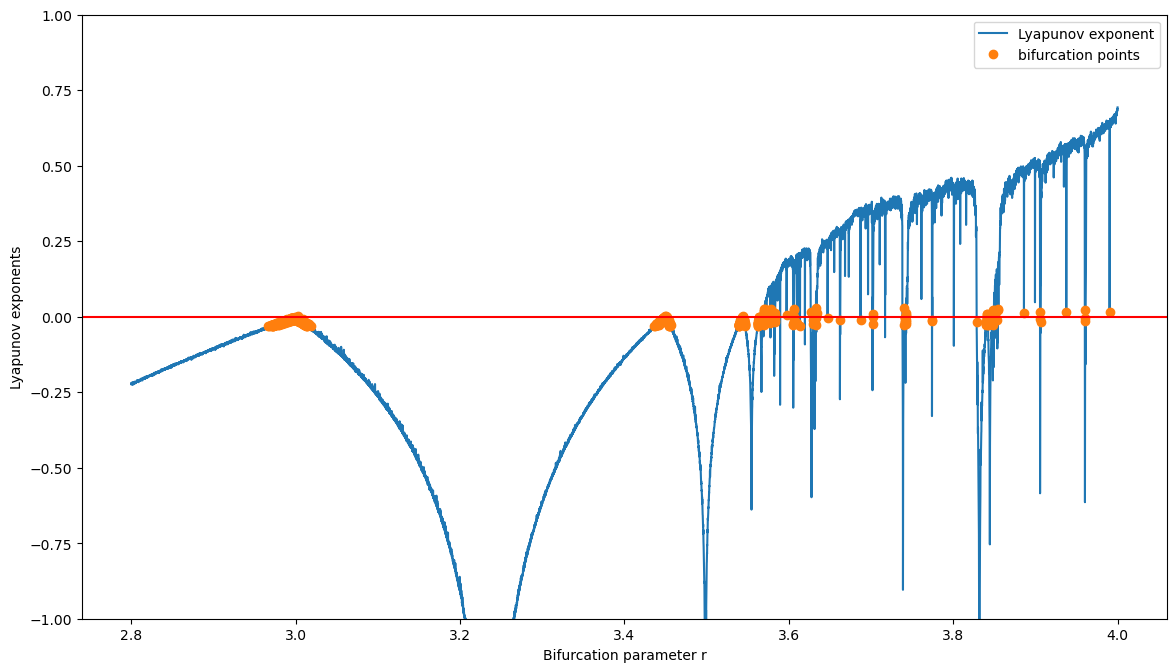

In [86]:
index = np.where(np.abs(L) <= 3e-2)[0]


plt.figure(figsize=(14,8), dpi=100)
plt.plot(R, L, label="Lyapunov exponent")
plt.plot(R[index], L[index], "o", label="bifurcation points")


X = np.concatenate([R[index][:,None],L[index][:,None]], axis=1)
#cluster = DBSCAN(0.002, min_samples=2).fit(X)
#cluster = KMeans(13).fit(X)
#plt.plot(*cluster.components_.T, "k.", label="identified cluster");

plt.ylim(-1, 1)
plt.axhline(0, color="red")
plt.ylabel("Lyapunov exponents")
plt.xlabel("Bifurcation parameter r")
plt.legend()
#plt.show()
#plt.savefig("Lyapunov exponents for logistuic map", bbox_inches="tight")

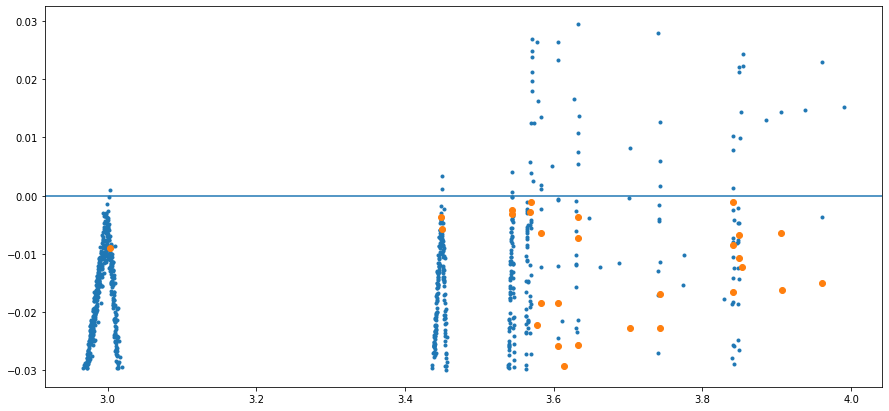

In [123]:
import numpy as np

def elements_before_positive(arr):
    before_positive = np.zeros(arr.shape)
    for i in range(len(arr) - 1):
        if arr[i] < 0 and arr[i + 1] > 0:
            before_positive[i] = arr[i]
    return before_positive


y = elements_before_positive(L[index])
#j = np.where(y  L[index])

plt.plot(R[index], L[index], ".")
plt.plot(R[index][y == L[index]], L[index][y == L[index]], "o")
plt.axhline(0)

In [99]:
result

array([1., 2.])

# Task 3

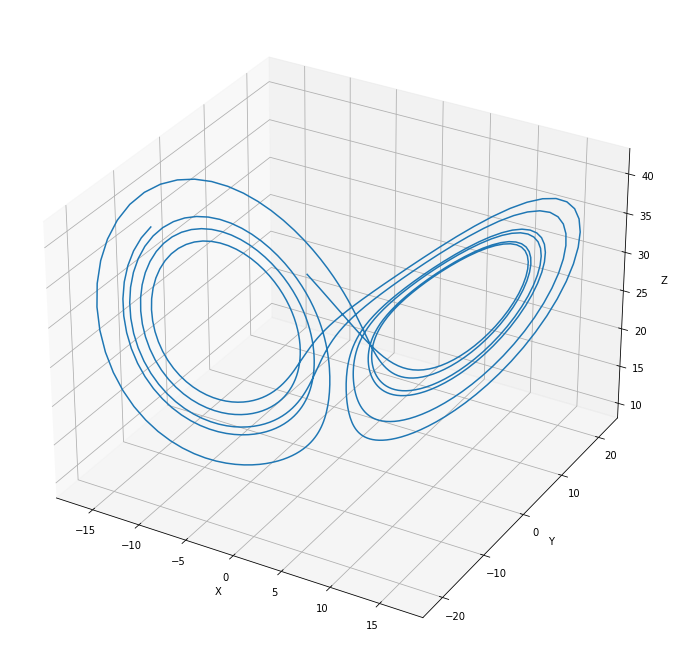

In [15]:
# plotting the solutions to the Lorentz system
def plot_array_3d(arr):
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(*arr.T)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()
    
# runge-kutta fourth-order numerical integration
@njit
def rk4(func, tk, _yk, _dt=0.01):
    """
    single-step fourth-order numerical integration (RK4) method
    func: system of first order ODEs
    tk: current time step
    _yk: current state vector [y1, y2, y3, ...]
    _dt: discrete time step size
    **kwargs: additional parameters for ODE system
    returns: y evaluated at time k+1
    """

    # evaluate derivative at several stages within time interval
    f1 = func(tk, _yk)
    f2 = func(tk + _dt / 2, _yk + (f1 * (_dt / 2)))
    f3 = func(tk + _dt / 2, _yk + (f2 * (_dt / 2)))
    f4 = func(tk + _dt, _yk + (f3 * _dt))

    # return an average of the derivative over tk, tk + dt
    return _yk + (_dt / 6) * (f1 + (2 * f2) + (2 * f3) + f4)

@njit
def lorenz(_t, _y, sigma=10, beta=(8 / 3), rho=28):
    """
    lorenz chaotic differential equation: dy/dt = f(t, y)
    _t: time tk to evaluate system
    _y: 3D state vector [x, y, z]
    sigma: constant related to Prandtl number
    beta: geometric physical property of fluid layer
    rho: constant related to the Rayleigh number
    return: [x_dot, y_dot, z_dot]
    """
    return np.array([
        sigma * (_y[1] - _y[0]),
        _y[0] * (rho - _y[2]) - _y[1],
        (_y[0] * _y[1]) - (beta * _y[2]),
    ])

yk = np.array([-7, 8, 26])

dt = 0.01
time = np.arange(0.0, 20, dt)
state_history = []

# iterate over time
for t in time:
    state_history.append(yk)
    yk = rk4(lorenz, t, yk, dt)
    
state_history = np.array(state_history)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.plot(*state_history.T)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
#plt.savefig("lorenz attractor", bbox_inches="tight")

# Task 4
1. Choose some initial condition such that it is attracted by the Lorentz system.
2. Definition of Lyapunov exponent: 
$$\lambda = \frac{1}{n}\sum_{i=0}^{n-1}\ln{\abs{f'(x_i)}}$$. What happens when $n$ becomes big? Is $\lambda$ positive or negative? What does it mean?

In [261]:
sigma = 10 
rho = 28 
beta = 8/3

yk = np.array([-7, 8, 26])

dt = 0.01
time = np.arange(0.0, 20, dt)
state_history = []
v = []

# iterate over time
for t in time:
    x, y, z = yk
    v.append(
        [sigma*(y-x), x*(rho-z) - y, x*y - beta*z]
    )
    
    state_history.append(yk)
    yk = rk4(lorenz, t, yk, dt)

    
state_history = np.array(state_history)
v = np.array(v)
Lyapunov_exponents = np.log(np.abs(v)).mean(0)
print(Lyapunov_exponents, "for x, y, z")

[3.2418655  3.26999055 3.85881722] for x, y, z


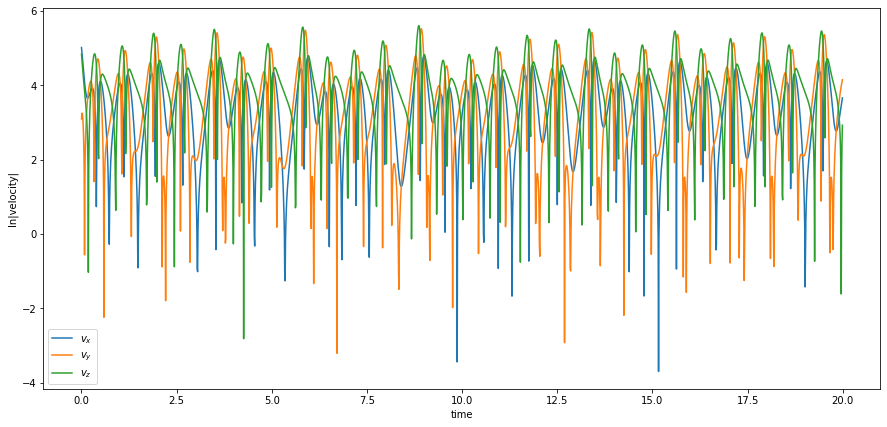

In [270]:
plt.plot(time, np.log(np.abs(v))[:,0], label="$v_x$")
plt.plot(time, np.log(np.abs(v))[:,1], label="$v_y$")
plt.plot(time, np.log(np.abs(v))[:,2], label="$v_z$")

plt.xlabel("time")
plt.ylabel("ln|velocity|")
plt.legend()
plt.savefig("log_abs_J", bbox_inches="tight")

In [248]:
state_history.shape

(2000, 3)